After trawlers, we're going to look at the whole group of ships, adding tags for gear type

In [2]:
import pandas as pd
import numpy as np
from collections import defaultdict

import swifter
import geopy.distance

import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interactive, FloatSlider

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score, plot_roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV, KFold

from joblib import dump, load
import os

import eda

import psycopg2 as pg
import sql_fish

RANDOM = 42
fishing_path = "./data/fishing boats/"

check if file with features is already generated

In [4]:
featurefile_name = fishing_path + "fishing_with_features.csv"
featurefile_generated = os.path.isfile(featurefile_name)

In [3]:
if featurefile_generated:
    exit()

gear_types = ["drifting_longlines", "fixed_gear", "pole_and_line", "purse_seines", "trawlers", "trollers", "unknown"]

fishing_raw_dfs = defaultdict(pd.DataFrame)

for gear_type in gear_types:
    fishing_raw_dfs[gear_type] = pd.read_csv(fishing_path + gear_type + ".csv", parse_dates=['timestamp'], date_parser=lambda col: pd.to_datetime(col, unit='s'))
    fishing_raw_dfs[gear_type]["gear_type"] = gear_type

In [4]:
if featurefile_generated:
    exit()

fishing_raw_df = pd.concat(fishing_raw_dfs, ignore_index=True)

In [5]:
if featurefile_generated:
    exit()

fishing_raw_df

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,source,gear_type
0,1.263956e+13,2012-01-21 09:01:44,232994.281250,311748.656250,8.2,230.500000,14.865583,-26.853662,-1.0,dalhousie_longliner,drifting_longlines
1,1.263956e+13,2012-01-21 09:03:25,233994.265625,312410.343750,7.3,238.399994,14.863870,-26.856800,-1.0,dalhousie_longliner,drifting_longlines
2,1.263956e+13,2012-01-21 09:05:34,233994.265625,312410.343750,6.8,238.899994,14.861551,-26.860649,-1.0,dalhousie_longliner,drifting_longlines
3,1.263956e+13,2012-01-21 10:54:41,233994.265625,315417.375000,6.9,251.800003,14.822686,-26.865898,-1.0,dalhousie_longliner,drifting_longlines
4,1.263956e+13,2012-01-21 10:55:41,233996.390625,316172.562500,6.1,231.100006,14.821825,-26.867579,-1.0,dalhousie_longliner,drifting_longlines
...,...,...,...,...,...,...,...,...,...,...,...
28581393,2.698965e+14,2016-11-23 11:43:42,16999.582031,33837.019531,5.5,142.600006,43.548107,13.784665,-1.0,gfw,unknown
28581394,2.698965e+14,2016-11-23 12:11:01,19234.912109,38482.820312,5.7,157.899994,43.511894,13.812785,-1.0,gfw,unknown
28581395,2.698965e+14,2016-11-23 13:09:03,18681.083984,47433.003906,5.4,284.899994,43.442558,13.845977,-1.0,gfw,unknown
28581396,2.698965e+14,2016-11-23 13:57:02,17463.820312,40310.296875,5.3,319.000000,43.493008,13.807993,-1.0,gfw,unknown


28 million rows, good grief! (6 million unknown)

In [6]:
if featurefile_generated:
    exit()

fishing_raw_df.is_fishing.value_counts()

-1.000000    28027543
 0.000000      295979
 1.000000      247498
 0.666667        4806
 0.333333        4096
 0.750000         752
 0.250000         670
 0.800000          33
 0.166667          12
 0.400000           9
Name: is_fishing, dtype: int64

Let's test to see if we can go a general algo for all types of fishing gear

In [ ]:
if featurefile_generated:
    fishing_raw_df = pd.read_csv(featurefile_name)
    exit()
else:
    fishing_raw_df['year'] = pd.DatetimeIndex(fishing_raw_df['timestamp']).year
    fishing_raw_df['month'] = pd.DatetimeIndex(fishing_raw_df['timestamp']).month
    fishing_raw_df['day'] = pd.DatetimeIndex(fishing_raw_df['timestamp']).day
    fishing_raw_df['hour'] = pd.DatetimeIndex(fishing_raw_df['timestamp']).hour
    fishing_raw_df['minute'] = pd.DatetimeIndex(fishing_raw_df['timestamp']).minute

    fishing_raw_df['is_new_mmsi'] = (fishing_raw_df.mmsi.shift(1) != fishing_raw_df.mmsi.shift(0))

    prev_list = ['speed', 'lat', 'lon']
    for col in prev_list:
        fishing_raw_df['prev_' + col] = fishing_raw_df[col].shift(1)
        fishing_raw_df['prev_' + col][fishing_raw_df.is_new_mmsi] = np.nan

    fishing_raw_df['dist_moved'] = fishing_raw_df[['lat', 'lon', 'prev_lat', 'prev_lon']].apply(eda.getdist, axis=1)

    fishing_raw_df['time_taken'] = fishing_raw_df.timestamp.diff(1)
    fishing_raw_df['time_taken'][fishing_raw_df.is_new_mmsi] = np.nan

In [5]:
if not featurefile_generated:
    fishing_raw_df.to_csv(featurefile_name, index=False)
else:
    connection = sql_fish.fishing_database()
    query = "SELECT * FROM fishingfeatures WHERE is_fishing != -1;"
    fishing_raw_df = pd.io.sql.read_sql(query, connection)


In [6]:
fishing_raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 553855 entries, 0 to 553854
Data columns (total 23 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   index                553855 non-null  int64         
 1   mmsi                 553855 non-null  float64       
 2   timestamp            553855 non-null  datetime64[ns]
 3   distance_from_shore  553855 non-null  float64       
 4   distance_from_port   553855 non-null  float64       
 5   speed                553853 non-null  float64       
 6   course               553853 non-null  float64       
 7   lat                  553855 non-null  float64       
 8   lon                  553855 non-null  float64       
 9   is_fishing           553855 non-null  float64       
 10  source               553855 non-null  object        
 11  gear_type            553855 non-null  object        
 12  year                 553855 non-null  int64         
 13  month         

In [7]:
fishing_raw_df

,index,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,...,month,day,hour,minute,is_new_mmsi,prev_speed,prev_lat,prev_lon,dist_moved,time_taken
0,22213007,2.162561e+13,2016-08-22 00:33:52,19312.734375,148161.812500,5.3,291.299988,-34.236973,23.476551,0.0,...,8,22,0,33,False,6.1,-34.272972,23.541151,7.165952,0 days 00:42:31.000000000
1,22213008,2.162561e+13,2016-08-22 00:52:24,18027.312500,151049.250000,8.4,61.200001,-34.218960,23.505659,0.0,...,8,22,0,52,False,5.3,-34.236973,23.476551,3.344437,0 days 00:18:32.000000000
2,22213009,2.162561e+13,2016-08-22 00:55:21,18600.619141,152048.890625,8.5,70.599998,-34.215881,23.512922,0.0,...,8,22,0,55,False,8.4,-34.218960,23.505659,0.751374,0 days 00:02:57.000000000
3,22213010,2.162561e+13,2016-08-22 01:13:50,19999.509766,156999.343750,8.3,64.800003,-34.196693,23.559826,0.0,...,8,22,1,13,False,8.5,-34.215881,23.512922,4.818278,0 days 00:18:29.000000000
4,22213011,2.162561e+13,2016-08-22 03:34:52,14035.324219,169495.109375,4.4,300.100006,-34.090069,23.664114,0.0,...,8,22,3,34,False,8.3,-34.196693,23.559826,15.244659,0 days 02:21:02.000000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
553850,22142734,2.101065e+13,2015-08-15 06:40:24,80527.515625,89093.265625,10.1,272.399994,36.081837,31.434946,0.0,...,8,15,6,40,False,10.2,36.080452,31.489010,4.872016,0 days 00:15:37.000000000
553851,22142735,2.101065e+13,2015-08-15 07:17:45,85420.382812,98856.054688,10.3,272.600006,36.086567,31.306494,0.0,...,8,15,7,17,False,10.1,36.081837,31.434946,11.581308,0 days 00:37:21.000000000
553852,22142736,2.101065e+13,2015-08-15 07:42:25,82853.257812,106829.023438,9.9,273.299988,36.088821,31.222900,0.0,...,8,15,7,42,False,10.3,36.086567,31.306494,7.532888,0 days 00:24:40.000000000
553853,22142737,2.101065e+13,2015-08-15 08:09:22,73788.437500,115118.851562,10.0,268.799988,36.089481,31.132254,0.0,...,8,15,8,9,False,9.9,36.088821,31.222900,8.164164,0 days 00:26:57.000000000


If we include all rows with no 'is_fishing' data, the resultant DataFrame is 4.5 GB with 28 MILLION records .... OTL (the CSV is even larger at almost 8 GB!)

Including only those with valid 'is_fishing' data yields a much more managable 93 MB with ~554k records

In [38]:
fishing_df = fishing_raw_df[(fishing_raw_df.is_fishing == 0) | (fishing_raw_df.is_fishing == 1)]
fishing_noconsensus_df = fishing_raw_df[(fishing_raw_df.is_fishing > 0) & (fishing_raw_df.is_fishing < 1)]

In [9]:
np.random.seed(RANDOM)
df_mask = np.random.rand(len(fishing_df)) < 0.8

fishing_train_df = fishing_df[df_mask].dropna()
fishing_test_df = fishing_df[~df_mask].dropna()

In [10]:
feature_cols = ['distance_from_shore', 'distance_from_port',
       'speed', 'course', 'lat', 'lon', 'year',
       'month', 'day', 'hour', 'minute', 'prev_speed',
       'dist_moved']

train_X = fishing_train_df[feature_cols]
train_y = fishing_train_df['is_fishing']

test_X = fishing_test_df[feature_cols]
test_y = fishing_test_df['is_fishing']

train_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 434795 entries, 0 to 553854
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   distance_from_shore  434795 non-null  float64
 1   distance_from_port   434795 non-null  float64
 2   speed                434795 non-null  float64
 3   course               434795 non-null  float64
 4   lat                  434795 non-null  float64
 5   lon                  434795 non-null  float64
 6   year                 434795 non-null  int64  
 7   month                434795 non-null  int64  
 8   day                  434795 non-null  int64  
 9   hour                 434795 non-null  int64  
 10  minute               434795 non-null  int64  
 11  prev_speed           434795 non-null  float64
 12  dist_moved           434795 non-null  float64
dtypes: float64(8), int64(5)
memory usage: 46.4 MB


In [11]:
model_knn = KNeighborsClassifier()

#create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_neighbors': np.arange(1, 25)}

#use gridsearch to test all values for n_neighbors
model_knn_gscv = GridSearchCV(model_knn, param_grid, cv=KFold(n_splits=5, shuffle=True, random_state=RANDOM))

#fit model to data
model_knn_gscv.fit(train_X, train_y)
model_knn_gscv.best_params_

{'n_neighbors': 1}

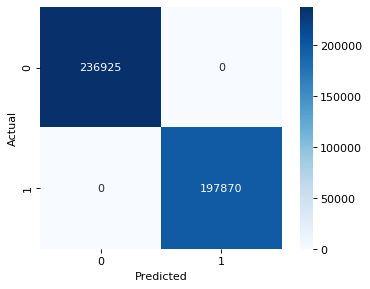

In [12]:
eda.make_confusion_matrix(model_knn_gscv, train_X, train_y, threshold=0.5)

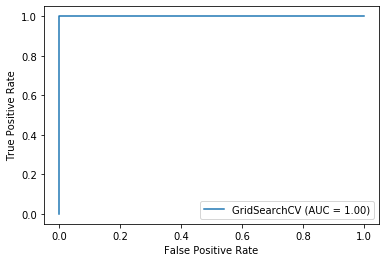

In [13]:
plot_roc_curve(model_knn_gscv, train_X, train_y);

Looks like overfitting again, just like with the smaller trawler dataset

In [14]:
model_logreg_cv = LogisticRegressionCV(cv=KFold(n_splits=5, shuffle=True, random_state=RANDOM))
model_logreg_cv.fit(train_X, train_y)

LogisticRegressionCV(Cs=10, class_weight=None,
                     cv=KFold(n_splits=5, random_state=42, shuffle=True),
                     dual=False, fit_intercept=True, intercept_scaling=1.0,
                     l1_ratios=None, max_iter=100, multi_class='auto',
                     n_jobs=None, penalty='l2', random_state=None, refit=True,
                     scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [15]:
interactive(lambda threshold: eda.make_confusion_matrix(model_logreg_cv, test_X, test_y, threshold=0.28, show_metrics=True), threshold=(0.0,1.0,0.01))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.01), Output()), _dom_cla…

In [16]:
threshold = 0.37

logreg_y = (model_logreg_cv.predict_proba(train_X)[:, 1] >= threshold)

f1_score(train_y, logreg_y)

0.6902051043894073

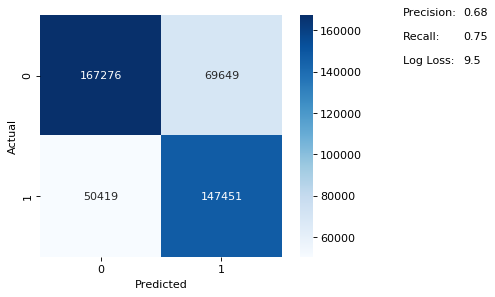

In [17]:
eda.make_confusion_matrix(model_logreg_cv, train_X, train_y, threshold=0.35, show_metrics=True)

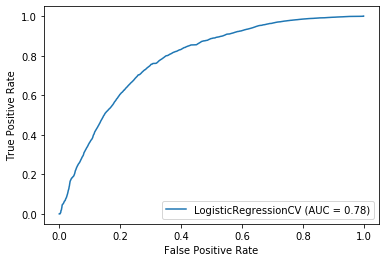

In [18]:
plot_roc_curve(model_logreg_cv, train_X, train_y);

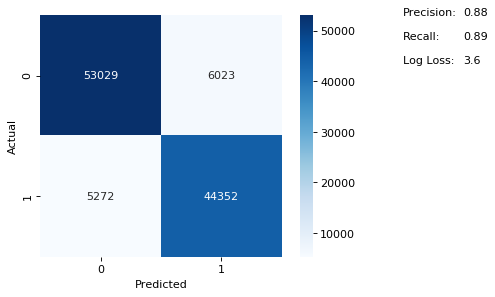

In [19]:
eda.make_confusion_matrix(model_knn_gscv, test_X, test_y, threshold=0.5, show_metrics=True)

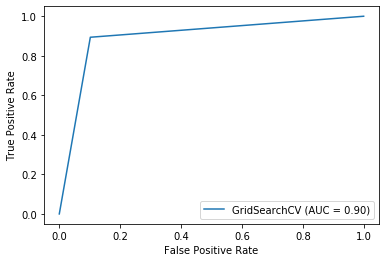

In [20]:
plot_roc_curve(model_knn_gscv, test_X, test_y);

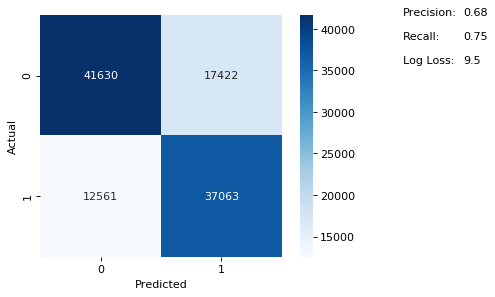

In [21]:
eda.make_confusion_matrix(model_logreg_cv, test_X, test_y, threshold=0.35, show_metrics=True)

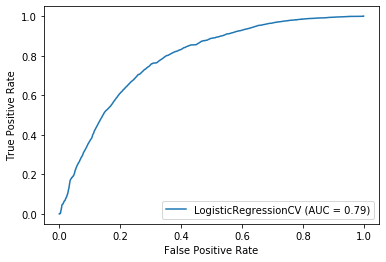

In [22]:
plot_roc_curve(model_logreg_cv, test_X, test_y);

KNN performs much better... but also has an extremely long training time

Let's save the two models

In [23]:
dump(model_knn_gscv, "knn_model_all.joblib")

['knn_model_all.joblib']

In [24]:
dump(model_logreg_cv, "lr_model_all.joblib")

['lr_model_all.joblib']

Let's see how the trawler models perform on the larger dataset

In [25]:
model_knn_trawler = load("knn_model_trawler.joblib")
model_knn2_trawler = load("knn2_model_trawler.joblib")
model_logreg_trawler = load("lr_model_trawler.joblib")

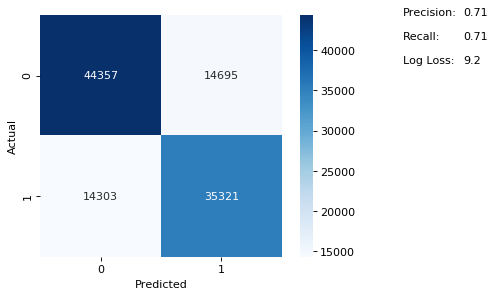

In [26]:
eda.make_confusion_matrix(model_logreg_trawler, test_X, test_y, threshold=0.28, show_metrics=True)

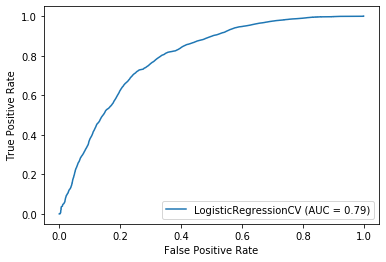

In [27]:
plot_roc_curve(model_logreg_trawler, test_X, test_y);

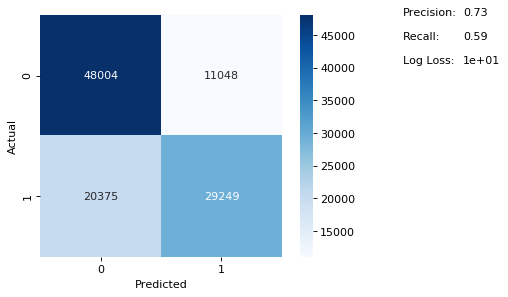

In [28]:
eda.make_confusion_matrix(model_knn_trawler, test_X, test_y, threshold=0.1, show_metrics=True)

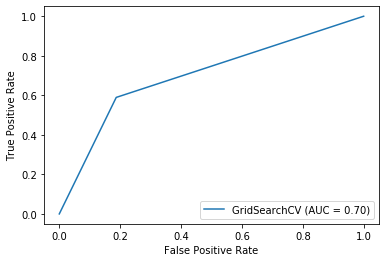

In [29]:
plot_roc_curve(model_knn_trawler, test_X, test_y);

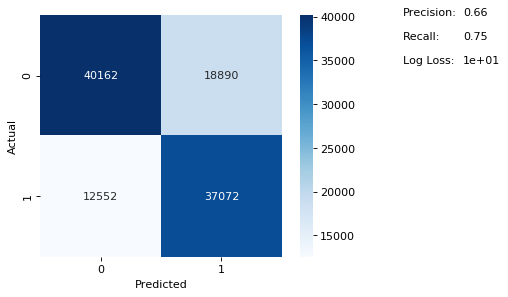

In [30]:
eda.make_confusion_matrix(model_knn2_trawler, test_X, test_y, threshold=0.01, show_metrics=True)

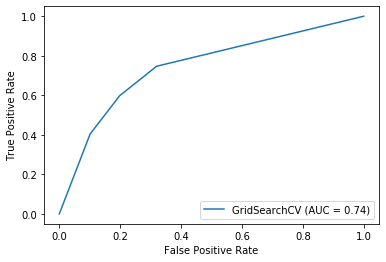

In [31]:
plot_roc_curve(model_knn2_trawler, test_X, test_y);

The overfitted KNN model appears to gradually perform worst with more unseen data, while the logistic regression model holds up much better. The second KNN (n_neighbour = 3) performs around the same as the logreg model, which is still a drop from its performance on trawlers alone.

Let's correct for KNN overfitting here too

In [32]:
model_knn2 = KNeighborsClassifier()

#create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_neighbors': np.arange(2, 25)}

#use gridsearch to test all values for n_neighbors
model_knn2_gscv = GridSearchCV(model_knn2, param_grid, cv=KFold(n_splits=5, shuffle=True, random_state=RANDOM))

#fit model to data
model_knn2_gscv.fit(train_X, train_y)
model_knn2_gscv.best_params_

{'n_neighbors': 3}

n_neighbours is 3 again

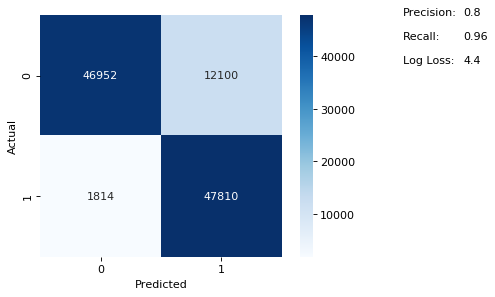

In [33]:
eda.make_confusion_matrix(model_knn2_gscv, test_X, test_y, threshold=0.01, show_metrics=True)

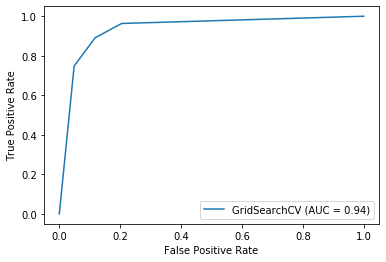

In [34]:
plot_roc_curve(model_knn2_gscv, test_X, test_y);

The best performance for now, but we've seen how the performance drops with more datapoints not in the original set.

In [35]:
dump(model_knn_gscv, "knn2_model_all.joblib")

['knn2_model_all.joblib']

Let's check against the non-consensus data

In [39]:
fishing_noconsensus_df = fishing_noconsensus_df.dropna()

noconsensus_X = fishing_noconsensus_df[feature_cols]
noconsensus_y = fishing_noconsensus_df['is_fishing']

In [43]:
noconsensus_y_knn = model_knn_gscv.predict(noconsensus_X)
noconsensus_y_knn2 = model_knn2_gscv.predict(noconsensus_X)
noconsensus_y_logreg = model_logreg_cv.predict(noconsensus_X)


ValueError: continuous format is not supported